In [1]:
####################Implementing the Kalman Filter Method####################################
import pybamm
import numpy as np
import matplotlib.pyplot as plt

pybamm.set_logging_level('INFO')

In [28]:
# Reverses the order of a list
# input: any list
# returns: the reversed-order list
def flipList(inputList):
    flippedList = list()
    for i in range(len(inputList)):
        flippedList.append(inputList[len(inputList) - i - 1])
    return flippedList


# Combines two lists to form a np.array
# inputs: two lists of x and y values
# returns: the np.array of the x and y values
def createArray(listX, listY):
    newList = list()
    for i in range(len(listX)):
        newList.append([listX[i], listY[i]])
    return np.array(newList)


# Creates a list of the modeled nth order polynomial fit values
# input: order n of the polynomial fit, list of experimental x values, list of experimental y values
# returns: a list of the modeled y-values using the polynomial fit
def getPolyFitValues(order, xList, yList):
    coefficients = np.polyfit(xList, yList, order)
    modeledValues = list()
    for x in xList:
        yVal = 0
        i = 0
        while order - i >= 0:
            yVal += coefficients[i] * x ** (order - i)
            i += 1
        modeledValues.append(yVal)
    return modeledValues


# Finds the chi-square value for experimental and modeled values
# inputs: list of experimental x-values, list of experimental y-values, list of modeled y-values
# returns: the chi-squared value
def getChiSquaredValue(experimentalValues, modeledValues):
    # Calculate the chi-squared value
    totalChiSquared = 0
    for i in range(len(experimentalValues)):
        expectedValue = modeledValues[i]
        observedValue = experimentalValues[i]
        if expectedValue != 0:
            totalChiSquared += abs(((observedValue - expectedValue)**2) / expectedValue)
        elif abs(observedValue - expectedValue) <= 0.000001:
            totalChiSquared += 0
        else:
            totalChiSquared += (observedValue + expectedValue)**2
    return totalChiSquared


# Finds the optimal order n of a polynomial fit using minimum chi-square analysis
# inputs: a list of experimental x values (OCV measurements) and list of experimental y values (normalized SoC)
# returns: a list object of [order n, chi-squared value of the nth order fit], where n is the optimal order fit
def findOptimalOrderFit(xValues, yValues):
    # Only checks order n=1:8 to minimize compute time
    n = 1
    chiSquaredResults = list()
    while n <= 8:
        currentChiSquared = getChiSquaredValue(yValues, getPolyFitValues(n, xValues, yValues))
        chiSquaredResults.append([n, currentChiSquared])
        n += 1
    # find the minimum order n
    minIndex = 0
    minChiSquared = 1000000000.0
    for i in range(len(chiSquaredResults)):
        if chiSquaredResults[i][1] < minChiSquared:
            minChiSquared = chiSquaredResults[i][1]
            minIndex = i
    # the returned object is of the form [order n, chi-squared value]
    return chiSquaredResults[minIndex]


# Prints the optimal order n, chi-squared value of the fit, and coefficients of the polynomial fit
# inputs: the chiSquaredResults output of findOptimalOrderFit(), a list of experimental x values (OCV measurements),
#         and list of experimental y values (normalized SoC)
# returns: none
def printFittingResults(chiSquaredResults, xValues, yValues):
    # prints the optimal order n
    print("Optimal Order Fit:", chiSquaredResults[0])
    # prints the chi-squared value of the fit
    print("Chi-Squared Value:", chiSquaredResults[1])
    # prints the coefficients of the optimal fit
    print("Coefficients:")
    coefficientList = np.polyfit(xValues, yValues, chiSquaredResults[0])
    order = chiSquaredResults[0]
    for i in range(len(coefficientList)):
        print("\tx^" + str(order - i) +":", coefficientList[i])

In [4]:
model = pybamm.lithium_ion.DFN()
parameter_values = pybamm.ParameterValues('Chen2020')
experiment = pybamm.Experiment([(
    'Discharge at 0.2 C until 2.5 V',
    'Rest for 4 hours',
    'Charge at 0.2 C until 4.2 V',
    'Discharge at C/20 until 2.5 V'
)])

simulation = pybamm.Simulation(model=model, experiment=experiment, parameter_values=parameter_values)
sol = simulation.solve()

In [21]:
sol.plot(['Terminal voltage [V]', 'Current [A]', 'Measured open circuit voltage [V]', 'Negative electrode capacity [A.h]', 'Discharge capacity [A.h]'])

interactive(children=(FloatSlider(value=0.0, description='t', max=33.395267655617594, step=0.33395267655617594…

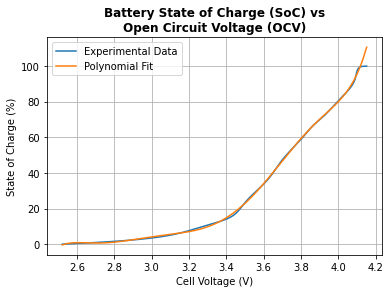

In [26]:
discharge_step = sol.cycles[0].steps[3]

measurements_adjusted = discharge_step['Discharge capacity [A.h]'].entries
voltage_reading_final = flipList(discharge_step['Measured open circuit voltage [V]'].entries)

num_measurements = len(measurements_adjusted)
increment = 100.0/num_measurements
normalized_SoC = list()
tempI = 0
while tempI < num_measurements:
    normalized_SoC.append(tempI*increment)
    tempI += 1


# Finds the optimal order n of a polynomial fit of the data using minimum chi-square analysis
optimal_fit_values = findOptimalOrderFit(voltage_reading_final, normalized_SoC)
optimal_order = optimal_fit_values[0]

# Creates a list of modeled SoC values using the optimal polynomial fit, used for plotting
modeled_values = getPolyFitValues(optimal_order, voltage_reading_final, normalized_SoC)


plt.plot(voltage_reading_final, normalized_SoC, label='Experimental Data')
# Plots the modeled values using the polynomial fit for SoC vs OCV
plt.plot(voltage_reading_final, modeled_values, label='Polynomial Fit')
plt.legend(loc='best')
plt.ylabel('State of Charge (%)')
plt.xlabel('Cell Voltage (V)')
plt.title("Battery State of Charge (SoC) vs\nOpen Circuit Voltage (OCV)", fontweight='bold')
plt.grid(True)
# Adjust spacing of subplots
plt.subplots_adjust(wspace=0.35)
plt.show()

In [29]:
print("\nFITTING RESULTS")
print("---------------")
printFittingResults(optimal_fit_values, voltage_reading_final, normalized_SoC)


FITTING RESULTS
---------------
Optimal Order Fit: 7
Chi-Squared Value: 21.825432773648448
Coefficients:
	x^7: 422.51894897471726
	x^6: -9631.94102236754
	x^5: 93588.93732780911
	x^4: -502456.5791206263
	x^3: 1609875.5471661598
	x^2: -3078556.0335139297
	x^1: 3253758.04613077
	x^0: -1466398.3052811315
